In [247]:
import pandas as pd

# Read csv files
trainData = pd.read_csv('train.csv')
testData = pd.read_csv('test.csv')
trainData.shape, testData.shape

((891, 12), (418, 11))

In [248]:
# Print raw contents of the train data
trainData

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [249]:
trainData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [250]:
trainData.describe(include=['object'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


In [251]:
train_missing = (trainData.isnull().sum() / trainData.isnull().count() * 100).sort_values(ascending=False)
test_missing = (testData.isnull().sum() / testData.isnull().count() * 100).sort_values(ascending=False)
missing_values = pd.concat([train_missing, test_missing], axis=1, keys=['Train', 'Test'])
missing_values

,Train,Test
Cabin,77.104377,78.229665
Age,19.865320,20.574163
Embarked,0.224467,0.000000
PassengerId,0.000000,0.000000
Survived,0.000000,NaN
Pclass,0.000000,0.000000
Name,0.000000,0.000000
Sex,0.000000,0.000000
SibSp,0.000000,0.000000
Parch,0.000000,0.000000


<Axes: >

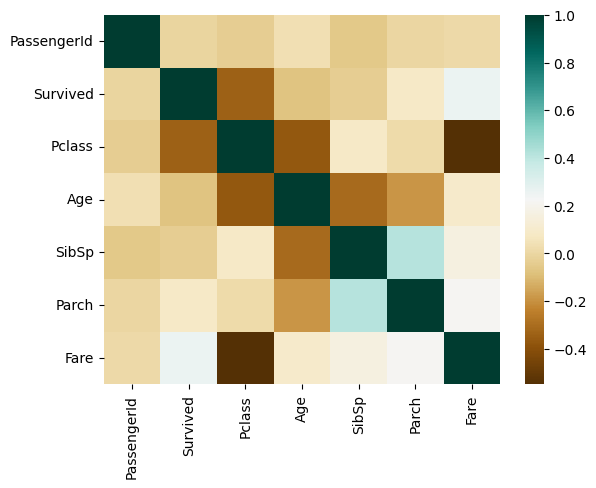

In [252]:
import seaborn as sns

sns.heatmap(trainData.select_dtypes(exclude=['object', 'category']).corr(), cmap='BrBG')

Заповнення пропусків

In [253]:
trainData['Embarked'].value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

Remove redundant columns that do not affect the analysis:
Fill in missing data in Embarked with the most frequent ones. 
In Fare, we fill in the missing values with the median.

For both datasets, ages are grouped by ticket class ('Pclass'), the average age for each class is calculated, and then the missing age values are filled with these average ages depending on the ticket class.

In [254]:
# Drop unnecessary columns
trainData = trainData.drop(['PassengerId', 'Cabin', 'Ticket'], axis=1)
testData = testData.drop(['Cabin', 'Ticket'], axis=1)

# Fill missing values
trainData['Embarked'] = trainData['Embarked'].fillna(trainData['Embarked'].mode()[0])
testData['Fare'] = testData['Fare'].fillna(testData['Fare'].median())

# Fill missing age values based on mean age of each Pclass
pclass_mean_age = trainData.groupby('Pclass')['Age'].mean()
trainData['Age'] = trainData.apply(lambda row: pclass_mean_age[row['Pclass']] if pd.isnull(row['Age']) else row['Age'], axis=1)
testData['Age'] = testData.apply(lambda row: pclass_mean_age[row['Pclass']] if pd.isnull(row['Age']) else row['Age'], axis=1)

# Process 'FamilySize', 'IsAlone', and 'Title' columns
for df in [trainData, testData]:
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = 1
    df.loc[df['FamilySize'] > 1, 'IsAlone'] = 0
    df['Title'] = df['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
    df.drop('Name', axis=1, inplace=True)
    
trainData

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,Title
0,0,3,male,22.00000,1,0,7.2500,S,2,0,Mr
1,1,1,female,38.00000,1,0,71.2833,C,2,0,Mrs
2,1,3,female,26.00000,0,0,7.9250,S,1,1,Miss
3,1,1,female,35.00000,1,0,53.1000,S,2,0,Mrs
4,0,3,male,35.00000,0,0,8.0500,S,1,1,Mr
...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.00000,0,0,13.0000,S,1,1,Rev
887,1,1,female,19.00000,0,0,30.0000,S,1,1,Miss
888,0,3,female,25.14062,1,2,23.4500,S,4,0,Miss
889,1,1,male,26.00000,0,0,30.0000,C,1,1,Mr


In [255]:
from sklearn.preprocessing import LabelEncoder
# Encode categorical variables
gender_dict = {
    'male': 0,
    'female': 1
}

trainData['Sex'] = trainData['Sex'].map(gender_dict)
testData['Sex'] = testData['Sex'].map(gender_dict)

# Encode Embarked column with 1 and 0, instead of True and False
trainData['Embarked_C'] = (trainData['Embarked'] == 'C').astype(int)
trainData['Embarked_Q'] = (trainData['Embarked'] == 'Q').astype(int)
trainData['Embarked_S'] = (trainData['Embarked'] == 'S').astype(int)

testData['Embarked_C'] = (testData['Embarked'] == 'C').astype(int)
testData['Embarked_Q'] = (testData['Embarked'] == 'Q').astype(int)
testData['Embarked_S'] = (testData['Embarked'] == 'S').astype(int)

# Drop the original Embarked column
trainData = trainData.drop('Embarked', axis=1)
testData = testData.drop('Embarked', axis=1)

# Convert title to code
label = LabelEncoder()
categorical_columns = ['Title']
code_columns = []
for df in [trainData, testData]:
    for column in categorical_columns:
        df[column] = label.fit_transform(df[column])
        code_columns.append(column)

# Print raw contents of the train data
trainData

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,FamilySize,IsAlone,Title,Embarked_C,Embarked_Q,Embarked_S
0,0,3,0,22.00000,1,0,7.2500,2,0,11,0,0,1
1,1,1,1,38.00000,1,0,71.2833,2,0,12,1,0,0
2,1,3,1,26.00000,0,0,7.9250,1,1,8,0,0,1
3,1,1,1,35.00000,1,0,53.1000,2,0,12,0,0,1
4,0,3,0,35.00000,0,0,8.0500,1,1,11,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,0,27.00000,0,0,13.0000,1,1,14,0,0,1
887,1,1,1,19.00000,0,0,30.0000,1,1,8,0,0,1
888,0,3,1,25.14062,1,2,23.4500,4,0,8,0,0,1
889,1,1,0,26.00000,0,0,30.0000,1,1,11,1,0,0


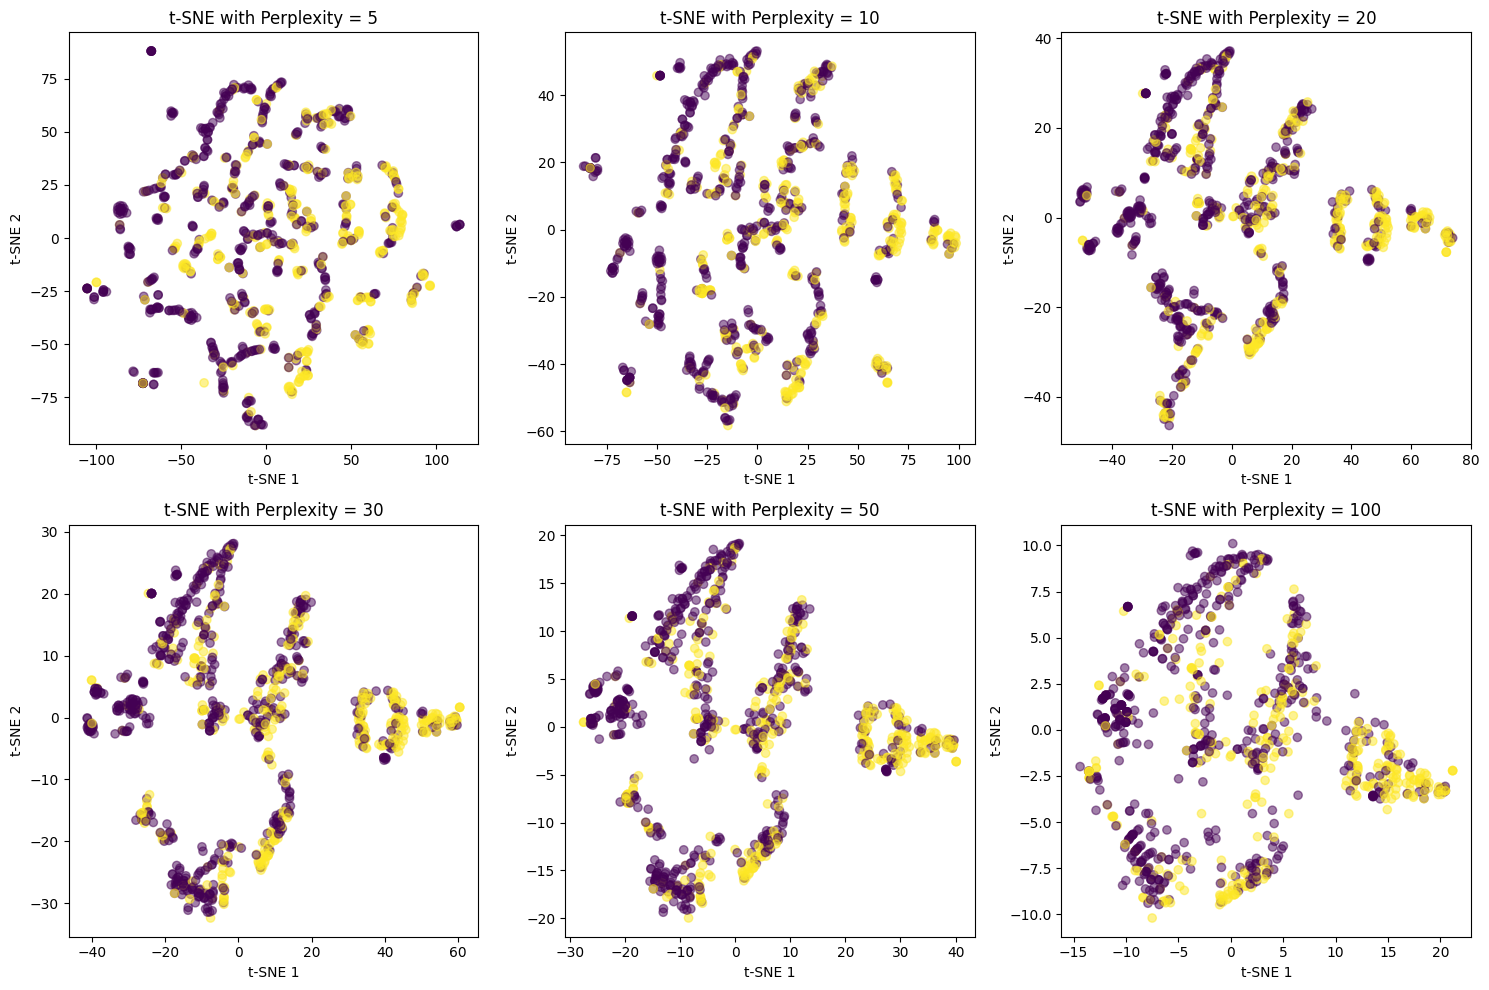

In [256]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

features = trainData.drop('Survived', axis=1)
perplexities = [5, 10, 20, 30, 50, 100]
tsne_results = {}

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, (perplexity, ax) in enumerate(zip(perplexities, axes.flatten())):
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
    tsne_embedding = tsne.fit_transform(features)
    tsne_results[perplexity] = tsne_embedding

    ax.scatter(tsne_embedding[:, 0], tsne_embedding[:, 1], c=trainData['Survived'], cmap='viridis', alpha=0.5)
    ax.set_title(f't-SNE with Perplexity = {perplexity}')
    ax.set_xlabel('t-SNE 1')
    ax.set_ylabel('t-SNE 2')

plt.tight_layout()
plt.show()


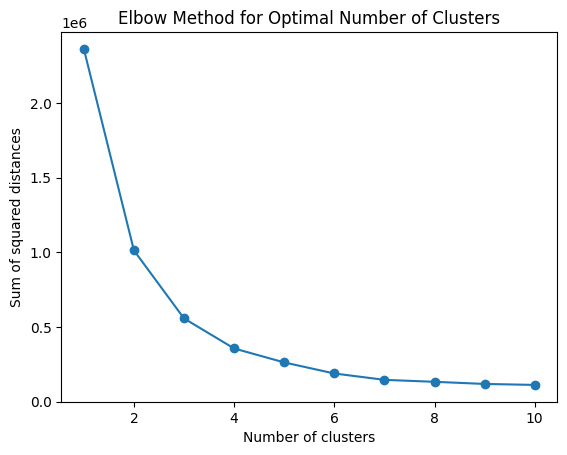

In [257]:
from sklearn.cluster import KMeans

sum_squared_distances = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(features)
    sum_squared_distances.append(kmeans.inertia_)

plt.plot(k_range, sum_squared_distances, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()

The optimal number of clusters can be considered 3, because after this point, the decrease 
in the sum of square distances is not as pronounced and curves, resembling the shape of an elbow. 

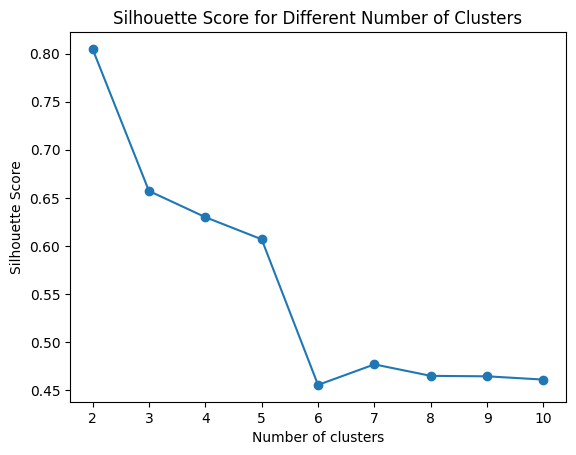

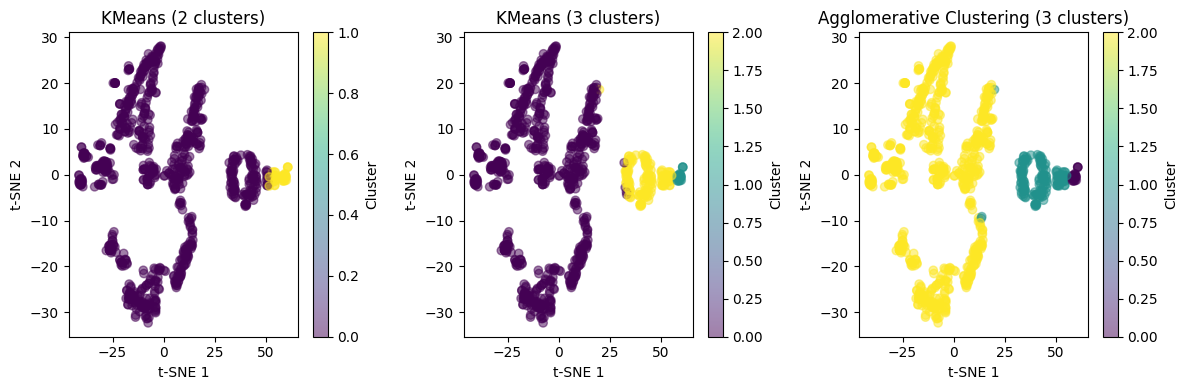

In [267]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, AgglomerativeClustering
import matplotlib.pyplot as plt

silhouette_scores = []
k_range = range(2, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    labels = kmeans.fit_predict(features)
    silhouette_scores.append(silhouette_score(features, labels))

plt.plot(k_range, silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different Number of Clusters')
plt.show()

# Clustering with KMeans with 2 clusters
kmeans_2 = KMeans(n_clusters=2, random_state=42)
labels_kmeans_2 = kmeans_2.fit_predict(features)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.scatter(tsne_results[30][:, 0], tsne_results[30][:, 1], c=labels_kmeans_2, cmap='viridis', alpha=0.5)
plt.title('KMeans (2 clusters)')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.colorbar(label='Cluster')

# Clustering with KMeans with 3 clusters
kmeans_3 = KMeans(n_clusters=3, random_state=42)
labels_kmeans_3 = kmeans_3.fit_predict(features)

plt.subplot(1, 3, 2)
plt.scatter(tsne_results[30][:, 0], tsne_results[30][:, 1], c=labels_kmeans_3, cmap='viridis', alpha=0.5)
plt.title('KMeans (3 clusters)')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.colorbar(label='Cluster')

# Clustering with Agglomerative Clustering
agglomerative = AgglomerativeClustering(n_clusters=3)
labels_agglomerative = agglomerative.fit_predict(features)

plt.subplot(1, 3, 3)
plt.scatter(tsne_results[30][:, 0], tsne_results[30][:, 1], c=labels_agglomerative, cmap='viridis', alpha=0.5)
plt.title('Agglomerative Clustering (3 clusters)')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.colorbar(label='Cluster')

plt.tight_layout()
plt.show()